## Libraries

In [232]:
import cv2
from PIL import Image
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, BatchNormalization, Dense, MaxPooling2D, Flatten, Dropout

from sklearn.metrics import classification_report, roc_curve, roc_auc_score

## Building Own Model

In [64]:
TRAIN_PATH = "./dataset/training_set/"
TEST_PATH = "./dataset/test_set//"

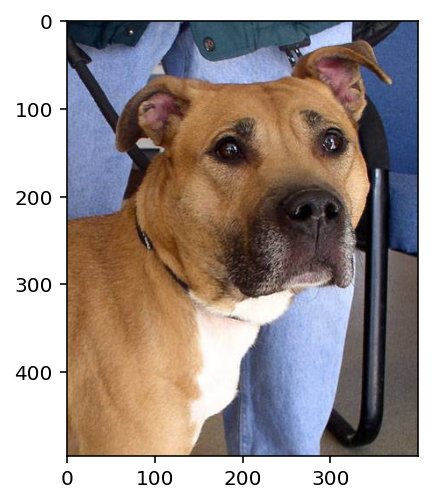

In [65]:
im = cv2.imread(os.path.join(TRAIN_PATH, "./dogs/dog.1067.jpg"))
img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(img);

In [66]:
datagen = ImageDataGenerator(rescale=1/255.,
                             rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")

train_generator = datagen.flow_from_directory(TRAIN_PATH,
                                              target_size=(150, 150),
                                              batch_size=40,
                                              class_mode="binary")

Found 8000 images belonging to 2 classes.


In [201]:
val_datagen = ImageDataGenerator(rescale=1/255.)
test_generator = val_datagen.flow_from_directory(TEST_PATH,
                                              target_size=(150, 150),
                                              batch_size=40,
                                              class_mode="binary", shuffle=False)

Found 2000 images belonging to 2 classes.


In [130]:
classes_labels = {value:key[:-1] for key, value in train_generator.class_indices.items()}

print(train_generator.class_indices)
print(test_generator.class_indices)

{'cats': 0, 'dogs': 1}
{'cats': 0, 'dogs': 1}


In [69]:
model = Sequential(layers=[
    Conv2D(filters=16, kernel_size=(3,3), activation="relu", input_shape=(150,150,3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=32, kernel_size=(3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation="sigmoid")    
])

In [70]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
batch_normalization_22 (Batc (None, 148, 148, 16)      64        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
batch_normalization_23 (Batc (None, 72, 72, 32)        128       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 34, 34, 64)       

In [71]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [72]:
model.fit_generator(generator=train_generator, steps_per_epoch=200, epochs=20,
                    validation_data=test_generator, validation_steps=50,verbose=1)

Epoch 1/20
200/200 [==============================] - 246s 1s/step - loss: 0.6953 - accuracy: 0.6071 - val_loss: 1.2091 - val_accuracy: 0.5000
Epoch 2/20
200/200 [==============================] - 218s 1s/step - loss: 0.6138 - accuracy: 0.6624 - val_loss: 0.8202 - val_accuracy: 0.5080
Epoch 3/20
200/200 [==============================] - 263s 1s/step - loss: 0.5833 - accuracy: 0.6895 - val_loss: 0.5320 - val_accuracy: 0.7135
Epoch 4/20
200/200 [==============================] - 272s 1s/step - loss: 0.5702 - accuracy: 0.7001 - val_loss: 0.5403 - val_accuracy: 0.7370
Epoch 5/20
200/200 [==============================] - 263s 1s/step - loss: 0.5598 - accuracy: 0.7103 - val_loss: 0.6235 - val_accuracy: 0.7680
Epoch 6/20
200/200 [==============================] - 269s 1s/step - loss: 0.5440 - accuracy: 0.7241 - val_loss: 0.4661 - val_accuracy: 0.7715
Epoch 7/20
200/200 [==============================] - 274s 1s/step - loss: 0.5280 - accuracy: 0.7336 - val_loss: 0.4017 - val_accuracy: 0.7570

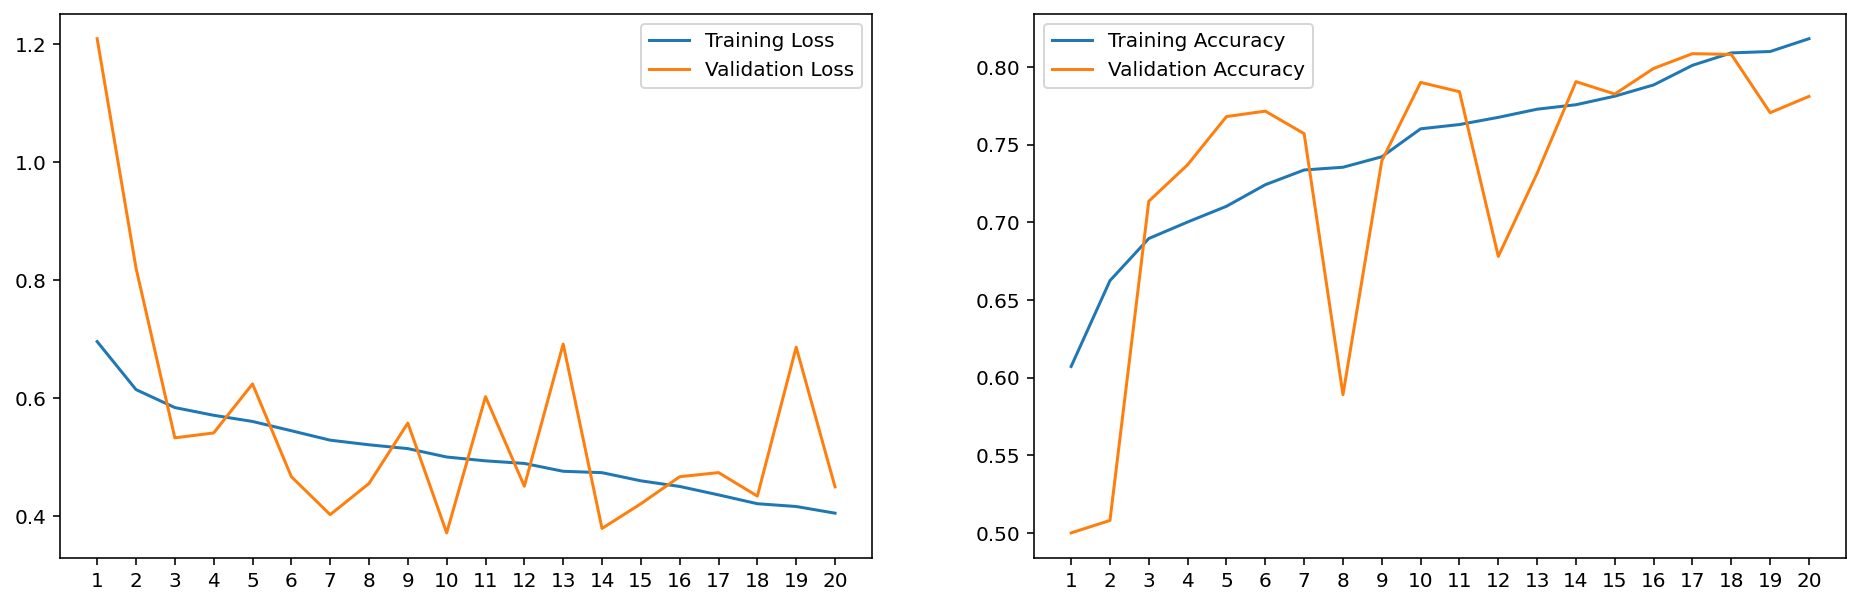

In [75]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,5))
x = np.linspace(1, 20, 20)
ax1.plot(x, model.history.history["loss"], label="Training Loss")
ax1.plot(x, model.history.history["val_loss"], label="Validation Loss")
ax1.xaxis.set_ticks(x)
ax1.legend()
ax2.plot(x, model.history.history["accuracy"], label="Training Accuracy")
ax2.plot(x, model.history.history["val_accuracy"], label="Validation Accuracy")
ax2.xaxis.set_ticks(x)
ax2.legend()
plt.show()

+ Testing images

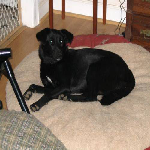

In [430]:
file_path = train_generator.filenames[np.random.randint(low=0, high=8000, size=1)[0]]
test_img = Image.open(os.path.join(TRAIN_PATH, file_path)).resize((150,150))
test_img

In [431]:
test = np.array(test_img.getdata()).reshape(1, test_img.size[0], test_img.size[1], 3)/255.
y_pred = 1 if model.predict(test)[0][0]>=0.5 else 0
y_proba = model.predict(test)[0][0] if y_pred==1 else 1-model.predict(test)[0][0]
print(f"This picture shows a {classes_labels[y_pred]} with probability of {100*y_proba:.2f}%")

This picture shows a dog with probability of 63.05%


### Metrics

In [202]:
y_true = test_generator.labels
y_proba = model.predict_generator(generator=test_generator)
y_pred = pd.Series(y_proba[:,0], name="Class").apply(lambda x: 1 if x>0.5 else 0)

+ Classification Report

In [203]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1000
           1       0.78      0.78      0.78      1000

    accuracy                           0.78      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.78      0.78      0.78      2000



+ Confusion Matrix

In [213]:
def confusion_matrix(y_true, y_pred):    
    matrix = pd.DataFrame(data=y_true, columns=["Class"])
    matrix.rename(columns={"Class": "Real"}, inplace=True)
    matrix["Predicted"] = y_pred.values
    matrix["Predicted"] = matrix["Predicted"].apply(lambda x: "Dog" if x==1 else "Cat")
    matrix["Real"] = matrix["Real"].apply(lambda x: "Dog" if x==1 else "Cat")
    return matrix.groupby(by=["Real", "Predicted"]).size().unstack()

In [214]:
confusion_matrix(y_true, y_pred)

Predicted,Cat,Dog
Real,,
Cat,784,216
Dog,222,778


+ ROC and AUC

In [217]:
def plot_roc(y_true, probabilities):
    fpr, tpr, thresholds = roc_curve(y_true, probabilities[:,0])
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    plt.plot(fpr, tpr, color="green", label=f"CNN (AUC = {roc_auc_score(y_true, probabilities):.3f})")
    plt.plot([0,1], [0,1], color="navy")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.xlim((0,1))
    plt.ylim((0,1.001))
    plt.legend(loc=4)
    plt.show()

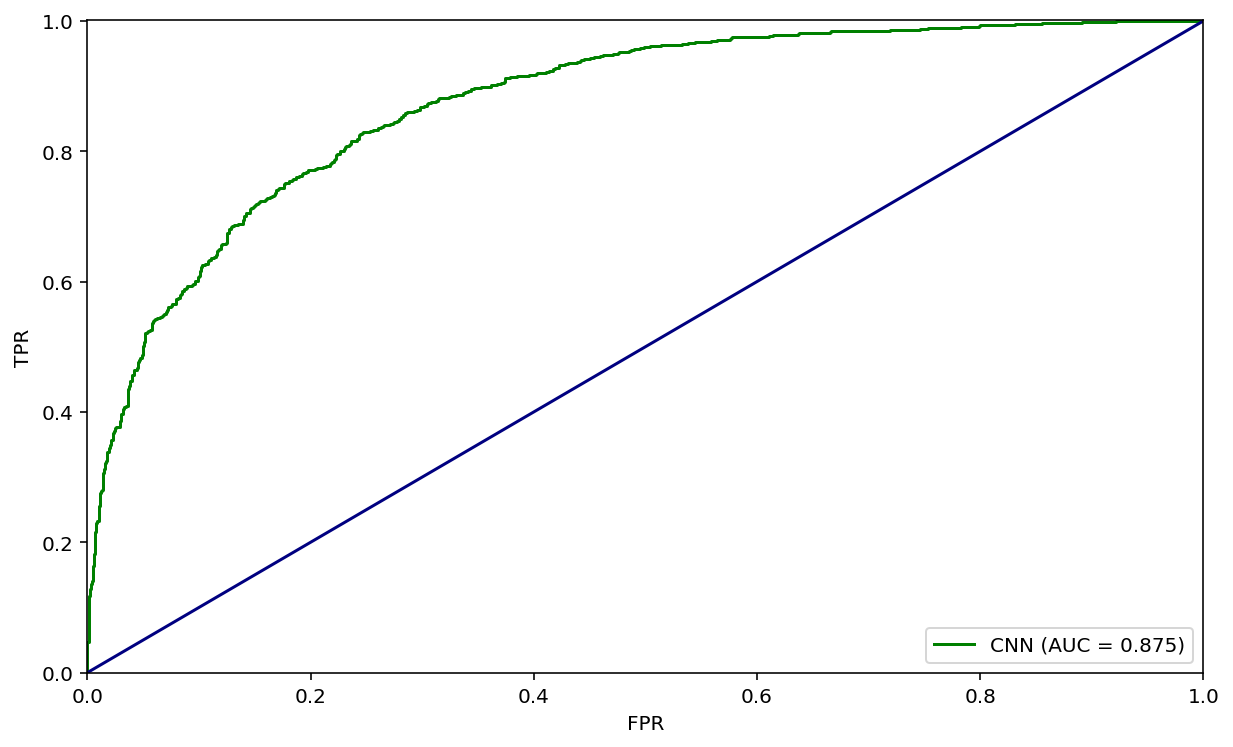

In [219]:
plot_roc(y_true, y_proba)

+ CAP

In [220]:
def plot_cap(y_true, probabilities):    
    base = pd.DataFrame(data=y_true, columns=["Class"])
    base.rename(columns={"Class": "Real"}, inplace=True)
    base["Probability"] = probabilities[:,0]
    total = len(base[base.Real==1])
    
    perfect = (base.sort_values(by="Real", ascending=False)["Real"].cumsum()/total).values
    model = (base.sort_values(by="Probability", ascending=False)["Real"].cumsum()/total).values
    perfect = np.concatenate([[0], perfect])
    model = np.concatenate([[0], model])
    
    x = np.linspace(0, len(base), len(base)+1)/len(base)
    
    max_area = 0
    actual_area = 0
    h = x[1]-x[0]
    for i, (m, a) in enumerate(zip(perfect, model)):
        try:
            max_area+=((m-x[i])+(perfect[i-1]-(x[i-1])))*h/2
            actual_area+=((a-x[i])+(model[i-1]-(x[i-1])))*h/2
        except:
            continue
    accuracy_ratio = actual_area/max_area
    
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    plt.plot(x, model, color="green", label=f"CNN (AR = {accuracy_ratio:.3f})")
    plt.plot(x, perfect, color="red", label="Perfect Model")
    plt.plot([0,1], [0,1], color="navy")
    plt.xlabel("Pics")
    plt.ylabel("Dogs Pics")
    plt.xlim((0,1))
    plt.ylim((0,1.01))
    plt.legend(loc=4)
    plt.show()
    
    return model, perfect, x

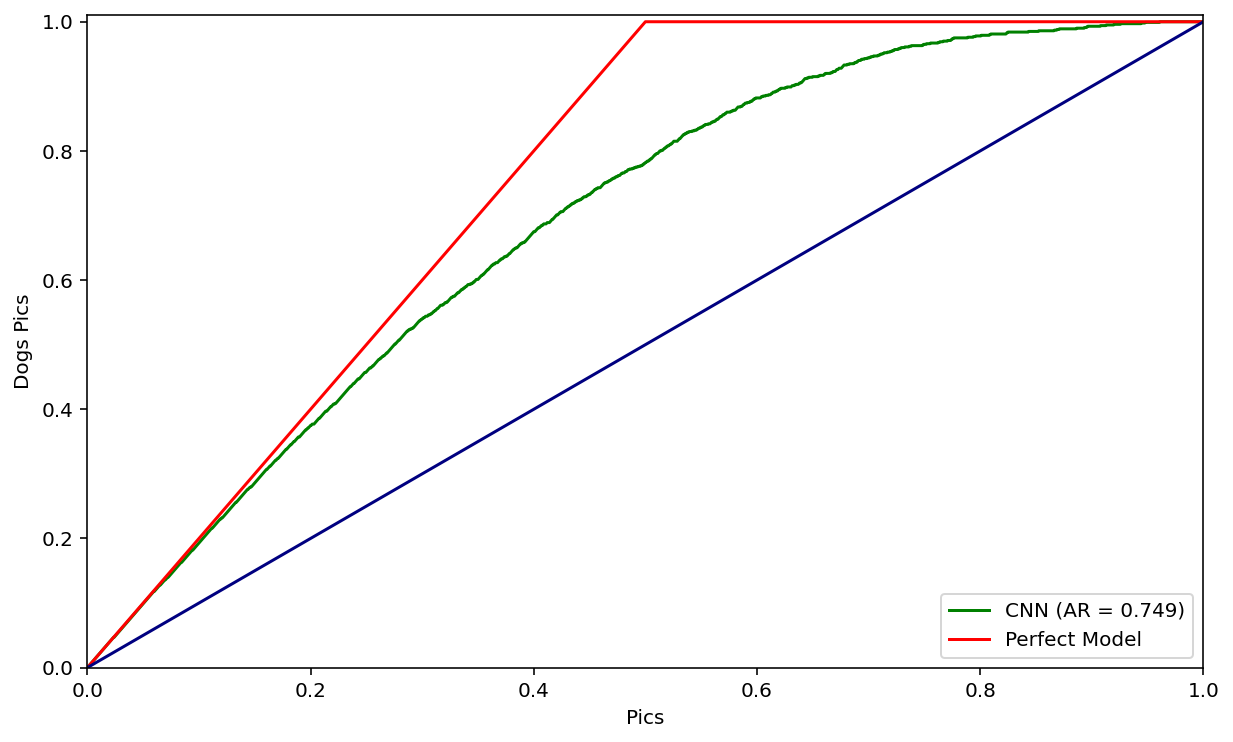

In [224]:
cap_model, cap_perfect, x = plot_cap(y_true, y_proba)

## Transfer Learning

In [225]:
from keras.applications.inception_v3 import InceptionV3

In [226]:
pre_trained_model = InceptionV3(input_shape=(150,150,3), include_top=False)


87916544/87910968 [==============================] - 50s 1us/step


In [249]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [250]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 74, 74, 32)   96          conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_27[0][0]     
_______________________________________________________________________________________

In [251]:
last_layer = pre_trained_model.get_layer("mixed7")
last_output = last_layer.output

In [254]:
x = Flatten()(last_output)
x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(1, activation="sigmoid")(x)

In [255]:
model = Model(pre_trained_model.input, x)

In [256]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [257]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 74, 74, 32)   96          conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_27[0][0]     
____________________________________________________________________________________________

In [269]:
model.fit_generator(generator=train_generator, steps_per_epoch=20, epochs=1,
                    validation_data=test_generator, validation_steps=50,verbose=1)

### Metrics

In [270]:
y_true = test_generator.labels
y_proba = model.predict_generator(generator=test_generator)
y_pred = pd.Series(y_proba[:,0], name="Class").apply(lambda x: 1 if x>0.5 else 0)

+ Classification Report

In [271]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.92      0.94      1000
           1       0.92      0.98      0.95      1000

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



+ Confusion Matrix

In [272]:
confusion_matrix(y_true, y_pred)

Predicted,Cat,Dog
Real,,
Cat,916,84
Dog,23,977


+ ROC and AUC

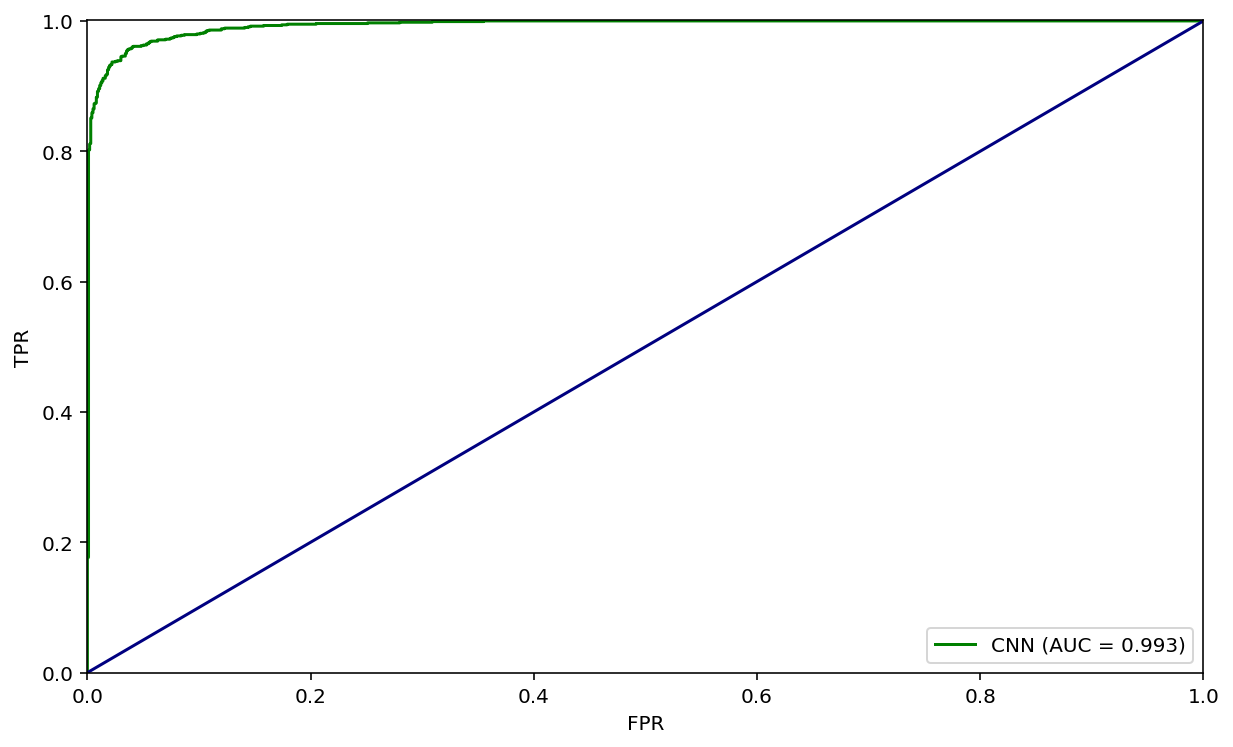

In [273]:
plot_roc(y_true, y_proba)

+ CAP

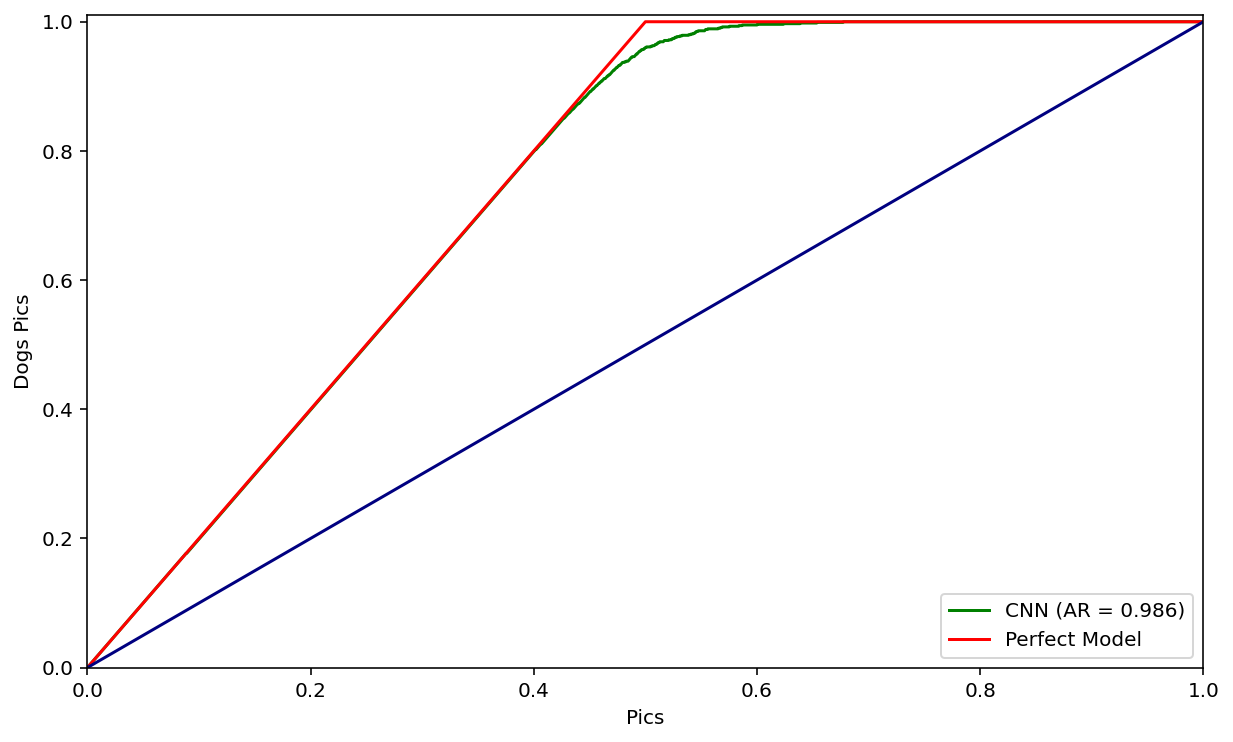

In [274]:
cap_model, cap_perfect, x = plot_cap(y_true, y_proba)